# Generate data

This notebook reads in the data files, creates a standardized DataFrame, and generates some plots for comparison to Kozar 2012.

***IF YOU RUN THIS NOTEBOOK IT WILL WRITE A FILE TO DISK***

For safety I have it check to see if the output data already exists.  If it does it will error instead of overwriting.  This is to be sure you are aware the file will be overwritten in case there are downstream dependencies

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os

In [2]:
def read_dat(filename, dataname, fallback_index=None):
    """
    Read the data files, convert to DataFrames
    """
    data = pd.read_csv(filename,
                        delim_whitespace=True,
                        header=None)
    if data.shape[1] == 2:
        # we have data with years
        data.set_index(0, inplace=True)
    elif data.shape[1] == 1:
        # no years - use fallback
        data.index = fallback_index
    else:
        raise Exception()
    data.index.name = None
    data.columns = [dataname]  
    return data

In [3]:
all_dat = glob.glob('*.dat')

In [4]:
all_dat

['NAO_MJ_mean_1870-2020.dat',
 'ERSSTv5_ASO_tropics_SST_anomalies_1870-2020.dat',
 'ERSSTv5_ASO_MDR_SST_1870-2020.dat',
 'ERSSTv5_ASO_tropics_SST_1870-2020.dat',
 'SahelPrecipIndex_JJAS_mean_1901-2017.dat',
 'NAO_DJFM_mean_1870-2020.dat',
 'Nino34_DJF_1870-2020.dat',
 'VK08_TCCounts_1878-2020.dat',
 'AMM_JJASOM_mean_1950-2020.dat',
 'HURDAT_TCCounts_1870-2020.dat',
 'Nino3_DJF_1870-2020.dat',
 'Nino12_DJF_1870-2020.dat',
 'ERSSTv5_ASO_MDRRelative_SST_1870-2020.dat',
 'ERSSTv5_ASO_MDR_SST_anomalies_1870-2020.dat']

In [5]:
DATAS = [('VK08_TCCounts_1878-2020.dat',                     'counts'     ),
         ('Nino34_DJF_1870-2020.dat',                        'nino34_djf' ),
         ('NAO_DJFM_mean_1870-2020.dat',                     'nao_djfm'   ),
         ('ERSSTv5_ASO_MDR_SST_anomalies_1870-2020.dat',     'mdr_aso'    ),
         ('SahelPrecipIndex_JJAS_mean_1901-2017.dat',        'sahel_jjas' ),
         ('Nino12_DJF_1870-2020.dat',                        'nino12_djf' ),
         ('Nino3_DJF_1870-2020.dat',                         'nino3_djf'  ),
         ('ERSSTv5_ASO_MDRRelative_SST_1870-2020.dat',       'relative_aso'),
         ('ERSSTv5_ASO_tropics_SST_anomalies_1870-2020.dat', 'tropic_aso' ),
         ('NAO_MJ_mean_1870-2020.dat',                       'nao_mj'     ),
         ('AMM_JJASOM_mean_1950-2020.dat',                   'amm_jjasom' )]

Let's just flag files that don't appear in the list above

In [6]:
print("Files not found in data manifest:\n")
for filename in all_dat:
    if filename not in [f for (f, _) in DATAS]:
        print(filename)

Files not found in data manifest:

ERSSTv5_ASO_MDR_SST_1870-2020.dat
ERSSTv5_ASO_tropics_SST_1870-2020.dat
HURDAT_TCCounts_1870-2020.dat


Assemble the data

In [7]:
datas = [read_dat(fn, col, fallback_index=tuple(range(1870, 2020+1))) for fn, col in DATAS]
data = pd.concat(datas, axis=1)
data.sort_index(inplace=True) # vk08 doesn't start until 1878

In [8]:
def plot_series(name, title, limits=True, data=data, axs=None):
    """
    foo: function that takes a year (eg tropic_aso)

    This is from `ERSSTv5.ipynb`
    """
    if axs is None:
        axs = plt
        axs.figure(figsize=(8, 3))
    df = data.loc[:, name]
    y = df.values
    years = df.index
    dy = y-np.nanmean(y)
    axs.plot(years, dy)
    if limits:
        axs.set_ylim(-1, 1)
    axs.set_xlim(years[0], years[-1])
    axs.fill_between(years, np.zeros_like(years), dy, where=dy>=0, color='red')
    axs.fill_between(years, np.zeros_like(years), dy, where=dy<=0, color='blue')
    axs.set_title(title, fontsize=10)
    axs.grid();

In [9]:
kozar_figs = [['mdr_aso', 'tropic_aso'],
              ['relative_aso', 'nao_mj'],
              ['nao_djfm', 'nino34_djf'],
              ['nino3_djf', 'nino12_djf'],
              ['sahel_jjas', 'amm_jjasom']]

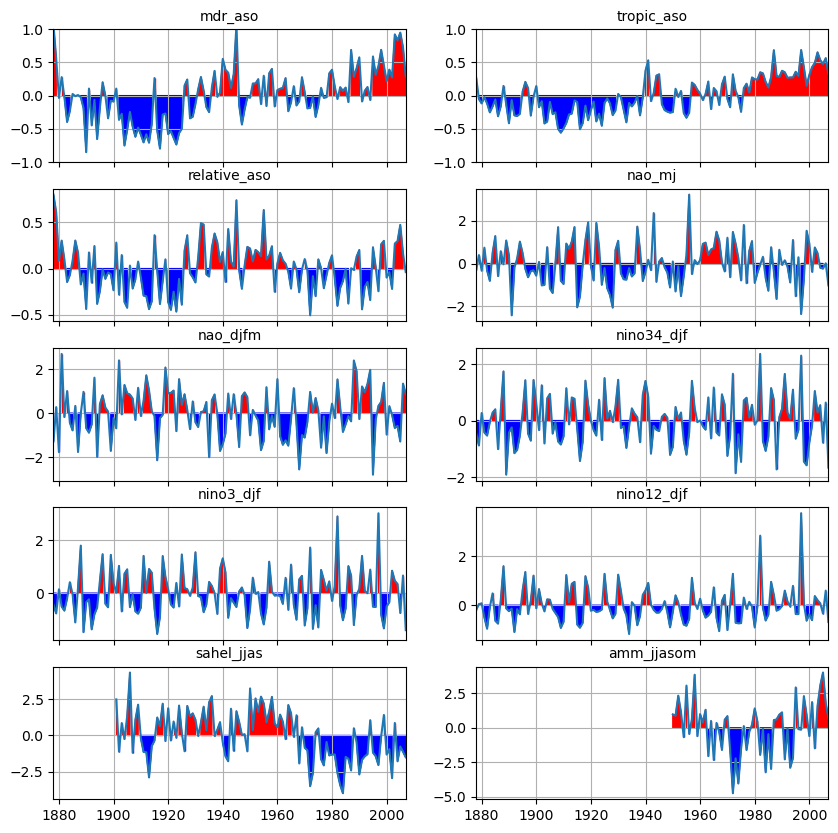

In [10]:
fig, axs = plt.subplots(5,2, sharex=True, figsize=(10,10))
for irow, row in enumerate(kozar_figs):
    for icol, col in enumerate(row):
        plot_series(col, col, axs=axs[irow, icol], data=data.loc[1878:2007, :],
                    limits=col in ['mdr_aso', 'tropic_aso'])

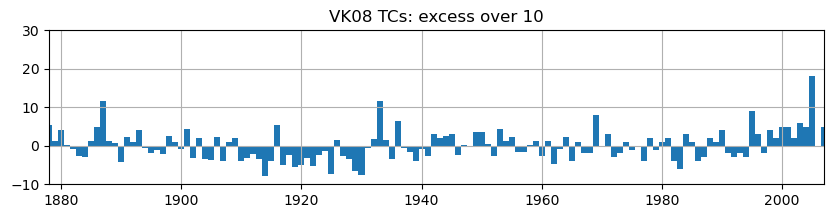

In [11]:
vk08tc = data.loc[1878:2007, 'counts']
plt.figure(figsize=(10,2))
plt.bar(vk08tc.index, vk08tc.values-10, width=1.0)
plt.title('VK08 TCs: excess over 10')
plt.ylim(-10, 30)
plt.xlim(vk08tc.index[0], vk08tc.index[-1])
plt.grid();

In [12]:
columns = ['nino34_djf', 'nino3_djf', 'nino12_djf', 'nao_djfm', 'nao_mj', 'mdr_aso', 'relative_aso', 'tropic_aso', 'amm_jjasom', 'sahel_jjas']
data.loc[1950:2007, columns].corr()

,nino34_djf,nino3_djf,nino12_djf,nao_djfm,nao_mj,mdr_aso,relative_aso,tropic_aso,amm_jjasom,sahel_jjas
nino34_djf,1.000000,0.965899,0.787001,0.081581,-0.005057,-0.016488,-0.479490,0.422102,-0.266382,-0.227195
nino3_djf,0.965899,1.000000,0.896163,0.128387,-0.063217,0.014637,-0.499543,0.478900,-0.271247,-0.268477
nino12_djf,0.787001,0.896163,1.000000,0.223607,-0.186971,0.052856,-0.444215,0.474875,-0.195767,-0.243298
nao_djfm,0.081581,0.128387,0.223607,1.000000,0.031151,-0.030991,-0.277111,0.217538,-0.198196,-0.106538
nao_mj,-0.005057,-0.063217,-0.186971,0.031151,1.000000,-0.263170,-0.046975,-0.280458,-0.171424,0.101236
mdr_aso,-0.016488,0.014637,0.052856,-0.030991,-0.263170,1.000000,0.601255,0.675643,0.700612,-0.113472
relative_aso,-0.479490,-0.499543,-0.444215,-0.277111,-0.046975,0.601255,1.000000,-0.182854,0.815928,0.476802
tropic_aso,0.422102,0.478900,0.474875,0.217538,-0.280458,0.675643,-0.182854,1.000000,0.109221,-0.579522
amm_jjasom,-0.266382,-0.271247,-0.195767,-0.198196,-0.171424,0.700612,0.815928,0.109221,1.000000,0.365549
sahel_jjas,-0.227195,-0.268477,-0.243298,-0.106538,0.101236,-0.113472,0.476802,-0.579522,0.365549,1.000000


In [13]:
data.loc[1950:2007].corr()['counts']

counts          1.000000
nino34_djf     -0.363717
nao_djfm       -0.319099
mdr_aso         0.530853
sahel_jjas      0.083849
nino12_djf     -0.293088
nino3_djf      -0.344002
relative_aso    0.528325
tropic_aso      0.165703
nao_mj         -0.232830
amm_jjasom      0.500041
Name: counts, dtype: float64

## Write data to disk

In [14]:
OUT_FILE = 'data.csv'

if os.path.exists(OUT_FILE):
    raise Exception("File \"{:s}\" exists, are you sure you want to overwrite?".format(OUT_FILE))
else:
    data.to_csv(OUT_FILE)
    print("Wrote \"{:s}\" to disk".format(OUT_FILE))

Wrote "data.csv" to disk
